**Learning Hugging Face Text Classification Model**



GPU Is needed -> Runtime -> Change Runtime Type -> GPU
- Use your own Hugging Face Key from Hugging Face Hub

In [1]:
# Install dependencies (for Google Colab)
import transformers
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install datasets evaluate accelerate gradio
  import datasets, evaluate, accelerate
  import gradio as gr

import random
import numpy as np
import pandas as pd
import torch

print(f"Using transformers version: {transformers.__version__}")
print(f"Using torch version: {torch.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using evaluate version: {evaluate.__version__}")
print(f"Using accelerate version: {accelerate.__version__}")


Using transformers version: 4.44.2
Using torch version: 2.5.0+cu121
Using datasets version: 3.1.0
Using evaluate version: 0.4.3
Using accelerate version: 0.34.2


In [ ]:
# Getting a Dataset
from datasets import load_dataset

ds = load_dataset("mrdbourke/learn_hf_food_not_food_image_captions")
ds

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [ ]:
ds.column_names

{'train': ['text', 'label']}

In [ ]:
#Access the training split
ds["train"][0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

In [ ]:
# Inspect random samples
import random
#classifying a sample to fit a unique list of 5 random indexes from the
#length of the dataset
random_indexs = random.sample(range(len(ds["train"])), 5)
#now accessing those random indices in the train dataset by
#referencing our dataset and setting it to grab the items
# at the random_indexs position
random_samples = ds["train"][random_indexs]
random_samples

for text, label in zip(random_samples["text"], random_samples["label"]):
  print(f'Text: {text} , Label : {label}')


Text: Pizza with a variety of toppings including mushrooms, olives, and bell peppers , Label : food
Text: Set of bowls stacked on a shelf , Label : not_food
Text: Artichokes in a bowl, sprinkled with garlic and served with a side of lemon aioli for a tasty, sophisticated dish. , Label : food
Text: Celery in a bowl, served with a side of peanut butter and a sprinkle of raisins for a classic, tasty snack. , Label : food
Text: Black leather couch adding elegance to a living room , Label : not_food


In [ ]:
ds['train'].unique('label')

['food', 'not_food']

In [ ]:
#Checking the count of each label
#How many occurences each label has in the dataset
from collections import Counter

Counter(ds['train']['label'])

Counter({'food': 125, 'not_food': 125})

In [ ]:
#Turn our dataset into a DataFrame and get a random sample of 7 items
food_not_food_df = pd.DataFrame(ds['train'])
food_not_food_df.sample(7)

,text,label
224,Stainless steel refrigerator with a convenient...,not_food
207,"Walking in the park, a man jogs with his energ...",not_food
88,A bowl of sliced kiwi with a sprinkle of sugar...,food
134,Set of oven mitts hanging on a hook,not_food
67,Potted plant adding greenery to a windowsill,not_food
16,A bowl of sliced honeydew with a sprinkle of s...,food
191,A bowl of pomegranate seeds with a sprinkle of...,food


In [ ]:
food_not_food_df['label'].value_counts()

,count
label,
food,125
not_food,125


In [ ]:
#4  Preparing data for text classification
# 1. Tokenize text
# 2. Creat a train/test split

#Create a mapping for labels to numeric value
id2label = {0: "not_food", 1: "food"}

label2id = {"not_food": 0, "food": 1}
print(id2label, label2id)

{0: 'not_food', 1: 'food'} {'not_food': 0, 'food': 1}


In [ ]:
#Creat mapping programatically from dataset
#Reminder: The enumerate keyword gives you the index of a certain element and that element name beside each other
#By creating these dictionary comprehensions we are setting the key equal to the index and value equal to the label value element

id2label = {idx: label for idx, label in enumerate(ds['train'].unique('label')[::-1])}
label2id = {label: idx for idx, label in id2label.items()}
id2label, label2id

({0: 'not_food', 1: 'food'}, {'not_food': 0, 'food': 1})

In [ ]:
gm#Turn labels into 0 or 1 depending on if food or not_food
def map_labels_to_number(example):
  example['label'] = label2id[example['label']]
  return example

example_sample = {"text" : "Sentence about the psychological issues in vaster than the empires by ursula k le guin", "label" : "food"}

map_labels_to_number(example_sample)


{'text': 'Sentence about the psychological issues in vaster than the empires by ursula k le guin',
 'label': 1}

In [ ]:
#Map our dataset labels to numbers (the whole thing)
# We do this with ds.map() -> https://huggingface.co/docs/datasets/en/about_map_batch

ds = ds['train'].map(map_labels_to_number)
ds[:5]


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [ ]:
ds.shuffle()[:5]

{'text': ['Set of napkins dispensed from a dispenser',
  'Jicama in a bowl, sprinkled with chili powder and served with a side of lime wedges for a refreshing snack.',
  'A close-up shot of a big orange pumpkin with a face cut out of the side for Halloween.',
  'A bowl of sliced cantaloupe with a sprinkle of cinnamon and a side of cottage cheese',
  'Rich and spicy lamb rogan josh with yogurt garnish, featuring tender lamb pieces in a bold sauce with spices, finished with creamy yogurt.'],
 'label': [0, 1, 1, 1, 1]}

### Split the dataset into training and test sets

* Train set = Model will learn patterns on this dataset
* Validation set = we can tune our model's hyperparameters on this set
* Test set = Model will evaluate patterns on this dataset


In [ ]:
ds = ds.train_test_split(test_size=0.2, seed=42)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [ ]:
#Create a random number for us to use to reference in our index
random_idx_train = random.randint(0, len(ds['train']))
#Now referencing that random number in our index
random_sample_train = ds['train'][random_idx_train]
random_sample_train

{'text': 'Friends having a barbecue in the backyard while pets play nearbyA collection of cleaning products under the sink',
 'label': 0}

In [ ]:
#Keeps generating random integers to use for testing this time
random_idx_test = random.randint(0, len(ds['test']))
random_sample_test = ds['test'][random_idx_test]
random_sample_test

{'text': 'Tangy tomato curry with chicken, featuring tender chicken pieces in a zesty tomato-based sauce with onions and spices.',
 'label': 1}

### Tokenizing our text data(turning text into numbers)


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path= "distilbert/distilbert-base-uncased", use_fast=True)
tokenizer



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
#Search what is attention mechanism
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

* input_ids = our text turned into numbers
* Attention_mask = whether or not to pay attention to certain tokens(1 = yes, 0 = no)

In [ ]:
# Get the length of our tokenizer vocab
length_tokenizer_vocab = len(tokenizer.vocab)
print(f'NUmber of items in our tokenizer vocab: {length_tokenizer_vocab}')
#Get the maximum sequence/character length the tokenizer can handle
max_sequence_length = tokenizer.model_max_length
print(f'Maximum sequence length the tokenizer can handle: {max_sequence_length}')


NUmber of items in our tokenizer vocab: 30522
Maximum sequence length the tokenizer can handle: 512


In [ ]:
#Does the name "john" occur in the vocab
tokenizer.vocab['john']

2198

In [ ]:
#If tokenizer does not know something then it is turned into the unknown token
tokenizer.convert_ids_to_tokens(tokenizer("😍").input_ids)


['[CLS]', '[UNK]', '[SEP]']

In [ ]:
sorted(tokenizer.vocab.items())[:5]


[('!', 999), ('"', 1000), ('#', 1001), ('##!', 29612), ('##"', 29613)]

In [ ]:
random.sample(sorted(tokenizer.vocab.items()), k=5)

[('several', 2195),
 ('##ability', 8010),
 ('nicholas', 6141),
 ('[unused502]', 507),
 ('##ras', 8180)]

### Making a preprocessing function to tokenize text in our dataframe
* Goes from sample -> tokenized_sample


In [ ]:
def tokenize_text(examples):
  return tokenizer(examples['text'], padding=True, truncation=True)
  # Padding and truncation change the length of the sample based on
  #the tokenizer's max model length
  #if too short padded to 512
  #if too long truncated to 512




In [ ]:
example_sample_2 = {"text": "I love pizza", 'label': 1}
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [ ]:
long_text = "I love pizza" * 1000
len(long_text)

12000

**Note** (batch functionality) This is particularly useful when you want to create batches of data for training or evaluation, especially when working with deep learning models.

In [ ]:
tokenized_long_text = tokenize_text({'text': long_text, 'label': 1})
len(tokenized_long_text['input_ids'])

512

In [ ]:
# Map our tokenize text function to the dataset

tokenized_ds = ds.map(tokenize_text, batched=True,# Tokenizes batches of samples at a time rather than one at a time to speed up the process
                      batch_size=1000)
#Breaking down a big task into batches using the power of computer hardware parallelization

tokenized_ds

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [ ]:
#get two samples from the tokenized datasets
train_tokenized_sample = tokenized_ds['train'][0]
test_tokenized_sample = tokenized_ds['test'][0]
train_tokenized_sample

{'text': 'Set of headphones placed on a desk',
 'label': 0,
 'input_ids': [101,
  2275,
  1997,
  2132,
  19093,
  2872,
  2006,
  1037,
  4624,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [ ]:
for key in train_tokenized_sample.keys():
  print(f'Key: {key}')
  print(f'Train sample: {train_tokenized_sample[key]}')
  print(f'Test sample: {test_tokenized_sample[key]}')
  print()

Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

Key: label
Train sample: 0
Test sample: 1

Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



### Tokenization takeaways
1. Tokenizers = turn data into numbers(eg text -> map to number)
2. Many models are out there and have different tokenizers, Hugging face Auto" helps to match tokenizers to models
3.  Tokenization can happen in parallel using 'map' and batched functions.

### Setting up an evaluation metric for our model
For classification machine learning problems common evaluation metrics for a model include:
* Accuracy (how many examples out of 100, did you match the label to the text correctly)
* Precision
* Recall
* F1-Score

In [ ]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load('accuracy')
def compute_accuracy(predictions_and_labels: Tuple[np.ndarray, np.ndarray]):
  """
  Computes the accuracy of a model by comparing the predicitions made to the labels
  """
  predictions, labels = predictions_and_labels
  return accuracy_metric.compute(predictions=predictions, references=labels)



In [ ]:
# Example predictions and accuracy score
example_preds_all_correct = np.array([0,0,0,0,0,0,0,0,0,0])
example_preds_one_incorrect = np.array([0,0,0,0,0,0,0,0,0,1])

example_labels = np.array([0,0,0,0,0,0,0,0,0,0])

print(f'Model Accuracy: {compute_accuracy((example_preds_all_correct, example_labels))}')
print(f'Model Accuracy: {compute_accuracy((example_preds_one_incorrect, example_labels))}')



Model Accuracy: {'accuracy': 1.0}
Model Accuracy: {'accuracy': 0.9}


### Setting up a model for transfer learning

1. Create data
2. Define model that we would like to use and customize it for our own task
3. Define training arguments for training our model 'tansformer.TrainingArguments'
4. Train the model by passing the training argument to the .train() method


In [ ]:
from transformers import AutoModelForSequenceClassification

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
num_labels = 2, id2label = id2label, label2id = label2id)



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

1. Embeddings  - form of learned representation of a token for a computer to understand. If there is a direct mapping embeddings will draw the vector representation of that mapping for the computer
2. Transformer - Model architecure backbone, Finds and discovers patterns/relationships within the Embeddings
3. Classifier - we need to customize the model to fit our task this is the main role of this attribute of the class


In [ ]:
tokenized_ds['train'][0]['attention_mask']

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

### Count the parameters in our model

Weights/parameters = small numeric opportunities for a model to learn patterns in data

In [ ]:
list(model.parameters())

def count_parameters(model):
  ''' count the number of trainable parameters in a model'''
  trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
  total_parameters = sum(p.numel() for p in model.parameters())
  return f'Trainable parameters: {trainable_parameters}\nTotal parameters: {total_parameters}'

count_parameters(model)


'Trainable parameters: 66955010\nTotal parameters: 66955010'

- Model has around 67 million parameters and all of them are able to be trained
- Generally the more parameters a model has then the more capacity it has to learn
- More precise models require more time for certain tasks but are more accurate
- Depends on the trade off generally smaller models can do the job just fine



In [ ]:
  #Create a model output directory
  from pathlib import Path

  models_dir = Path('models')
  models_dir.mkdir(exist_ok=True)
  #Create a model save name

  model_save_name = 'food_not_food_model'

  model_save_dir = Path(models_dir, model_save_name)


In [ ]:
model_save_dir

PosixPath('models/food_not_food_model')

### Setting Up Training  arguments

1. Create and preprocess data
2. Define the model we would like to use for our problem
3. Define the traning arguments for training our model ('transformers.TrainingArguments')
4. Train the model by passing the training arguments to the instance of transformers.Trainer
5. Train the model by calling Trainer.train()
6. Save the model (to local machine or Hugging Face Hub)
7. Evaluate the trained model by making and inspecting predictions
8. Turn the model into a shareable demo with front end


In [ ]:
from transformers import TrainingArguments

print(f'saving model checkpoint to : {model_save_dir}')

BATCH_SIZE = 32

training_args = TrainingArguments(output_dir = model_save_dir,
                                  learning_rate = 0.0001,
                                  per_device_train_batch_size = BATCH_SIZE,
                                  per_device_eval_batch_size = BATCH_SIZE,
                                  num_train_epochs = 10,
                                  # Number of Laps that model does around data
                                  eval_strategy = 'epoch',
                                  save_strategy = 'epoch',
                                  save_total_limit = 3,
                                  use_cpu = False,
                                  seed = 42,
                                  load_best_model_at_end = True,
                                  logging_strategy = 'epoch',
                                  report_to = 'none',
                                  #push_to_hub = True pushes the model to hub automatically after training is done
                                  hub_private_repo = False # When uploading to Hugging Face Hub make the repo public
                                  )


saving model checkpoint to : models/food_not_food_model


In [ ]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
from transformers import Trainer

trainer = Trainer(model = model,
                  args = training_args,
                  train_dataset = tokenized_ds['train'],
                  eval_dataset = tokenized_ds['test'],
                  tokenizer = tokenizer,
                  compute_metrics = compute_accuracy)

trainer

In [ ]:
input_predictions = np.array([[-1.4626725, 1.5296892]])



input_references =  np.array([0])
if len(input_predictions.shape) >= 2:
    input_predictions = np.argmax(input_predictions, axis=1)

input_predictions


array([1])

In [ ]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load('accuracy')
def compute_accuracy(predictions_and_labels: Tuple[np.ndarray, np.ndarray]):
  """
  Computes the accuracy of a model by comparing the predicitions made to the labels
  """
  predictions, labels = predictions_and_labels


  if len(predictions.shape) >= 2:
    #Re defining our compute accuracy function to include this conditional statement to ensure each item
    # is a tuple of length 2
    predictions = np.argmax(predictions, axis=1)
    #Using the argmax function to obtain the index of the tuple
    #which has the maximum value
    # as this number is the highest probability


  return accuracy_metric.compute(predictions=predictions, references=labels)


In [ ]:
compute_accuracy(predictions_and_labels = (input_predictions, input_references))

{'accuracy': 0.0}

In [ ]:
from transformers import Trainer

trainer = Trainer(model = model,
                  args = training_args,
                  train_dataset = tokenized_ds['train'],
                  eval_dataset = tokenized_ds['test'],
                  tokenizer = tokenizer,
                  compute_metrics = compute_accuracy)

trainer

In [ ]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.429500,0.087286,1.000000
2,0.045900,0.007889,1.000000
3,0.005300,0.003299,1.000000
4,0.001900,0.001525,1.000000
5,0.001100,0.000954,1.000000
6,0.000800,0.000727,1.000000
7,0.000700,0.000625,1.000000
8,0.000600,0.000574,1.000000
9,0.000600,0.000549,1.000000
10,0.000500,0.000541,1.000000


In [ ]:
for key, value in results.metrics.items():
  print(f"{key}: {value}")

train_runtime: 61.8806
train_samples_per_second: 32.32
train_steps_per_second: 1.131
total_flos: 18110777160000.0
train_loss: 0.04869035825332893
epoch: 10.0


### Saving the model for later use

**Note** If you are saving a model to Google Colab it will dissapear from your Colab instance when the runtime disconnects all code needs to be re run and runtime needs to be restarted

In [ ]:
# Save model

trainer.save_model(output_dir= model_save_dir)
#model_save_dir was the local directory on google colab defined previously


### Inspect model training metrics

In [ ]:
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_metrics
trainer_history_training_time = trainer_history_all[-1]


In [ ]:
import pprint

#Extract eval and training metrics
trainer_history_training_set = []
trainer_history_eval_set = []

for item in trainer_history_metrics:
  item_keys = list(item.keys())
  if any('eval' in item for item in item_keys):
    trainer_history_eval_set.append(item)
  else:
    trainer_history_training_set.append(item)


# First two items in training and eval set
print("\nTraining Set")
pprint.pprint(trainer_history_training_set[:2])
print("\nEval Set")
pprint.pprint(trainer_history_eval_set[:2])




Training Set
[{'epoch': 1.0,
  'grad_norm': 2.8848209381103516,
  'learning_rate': 9e-05,
  'loss': 0.4295,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.14389002323150635,
  'learning_rate': 8e-05,
  'loss': 0.0459,
  'step': 14}]

Eval Set
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.08728610724210739,
  'eval_runtime': 0.0635,
  'eval_samples_per_second': 787.11,
  'eval_steps_per_second': 31.484,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.007889144122600555,
  'eval_runtime': 0.0575,
  'eval_samples_per_second': 869.83,
  'eval_steps_per_second': 34.793,
  'step': 14}]


### Taking a look at the loss curve

Loss curves = a good visualization of model's performance over time
Ideally, loss curves should trend downards


In [ ]:
# Create a pandas DataFrame for the training and evaluation metrics
trainer_history_train_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_train_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.4295,2.884821,0.00009,1.0,7
1,0.0459,0.143890,0.00008,2.0,14
2,0.0053,0.043256,0.00007,3.0,21
3,0.0019,0.023611,0.00006,4.0,28
4,0.0011,0.018173,0.00005,5.0,35


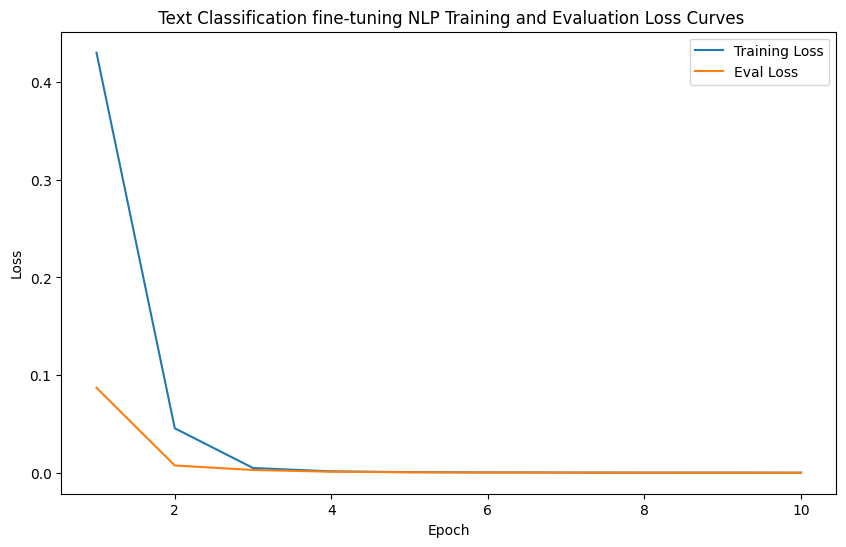

In [ ]:
#Plotting the loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(trainer_history_train_df['epoch'], trainer_history_train_df['loss'], label='Training Loss')
plt.plot(trainer_history_eval_df['epoch'], trainer_history_eval_df['eval_loss'], label='Eval Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(' Text Classification fine-tuning NLP Training and Evaluation Loss Curves')
plt.legend()
plt.show()


 ### Pushing the model to the hugging face hub

Why?
So our model can be shared and tested out by other people

Model versions can be tracked and compared

To write to hugging face:
- If on google Colab: setup "token" with "read and write" access
- If on local machine: setup hugging face CLI(command line interface)

Use trainer.push_to_hub method: https://huggingface.co/docs/diffusers/en/using-diffusers/push_to_hub


In [ ]:
# Save our model to the hugging face hub
model_upload_url = trainer.push_to_hub(commit_message="Uploading food not food text classification model")

print(f'Model succesfully uploaded to: {model_upload_url}')

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Model succesfully uploaded to: https://huggingface.co/ArhumCodes/food_not_food_model/tree/main/


### Making and evaluating predictions on the test data

In [ ]:
tokenized_ds['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [ ]:
predictions_all = trainer.predict(tokenized_ds['test'])
predictions_values = predictions_all.predictions
predictions_metrics = predictions_all.metrics
print(f" Prediction Metrics: \n {predictions_metrics}")

 Prediction Metrics: 
 {'test_loss': 0.0005413913750089705, 'test_accuracy': 1.0, 'test_runtime': 0.0956, 'test_samples_per_second': 523.013, 'test_steps_per_second': 20.921}


In [ ]:
predictions_all

PredictionOutput(predictions=array([[-3.934482 ,  3.8980134],
       [ 4.278147 , -3.302629 ],
       [-3.9503877,  3.8931215],
       [ 4.367949 , -3.3276439],
       [ 4.3064647, -3.3073702],
       [-3.9454122,  3.900223 ],
       [ 4.289883 , -3.2773552],
       [ 4.327923 , -3.3429985],
       [-3.948914 ,  3.8807204],
       [-3.9459193,  3.8902388],
       [-3.9572287,  3.8700528],
       [-3.893536 ,  3.868219 ],
       [ 4.31363  , -3.3125868],
       [-3.959614 ,  3.8815432],
       [-3.9312897,  3.8624153],
       [ 4.342585 , -3.3219311],
       [-3.9508662,  3.8785257],
       [ 4.2235665, -3.2282119],
       [-3.9452176,  3.885285 ],
       [-3.9526892,  3.883316 ],
       [-3.9352171,  3.8879142],
       [-3.952435 ,  3.8899438],
       [ 4.3315563, -3.312175 ],
       [ 4.3268275, -3.285535 ],
       [-3.95217  ,  3.8827379],
       [-3.9453015,  3.8912702],
       [-3.9452152,  3.8689346],
       [ 4.3359156, -3.2972772],
       [-3.9483247,  3.888742 ],
       [ 4.370

### Getting predicted probabilities and evaluating by hand

In [ ]:
import torch
from sklearn.metrics import accuracy_score

#1. Get prediction probabilities with torch.softmax

#Model output raw logits
predictions_values[0]

#The purpose of softmax is to get all values between 0 & 1 and the total of the values sum to 1
#This is what is known as our "prediction probability" the model is assigning
# the value to how "likely" the prediction is,  given the sample


pred_probs = torch.softmax(torch.tensor(predictions_values), dim=1)
pred_probs

#2. Get the predicted labels

pred_labels = torch.argmax(pred_probs, dim=1)
pred_labels

#3. Get the true labels

true_labels = tokenized_ds['test']['label']

# 4. Compute prediction labels to be true labels and get test accuracy
test_accuracy = accuracy_score(y_true = true_labels, y_pred = pred_labels)
print(f'Test Accuracy: {test_accuracy*100}')


# If you want a good evaluation method make predictions
# on your entire test dataset then reverse index on the
#predictions which are wrong but have high prediction probability






Test Accuracy: 100.0


### Exploring model's predcition probabilities

It's a very good way to evaluate a model by sortiing predictions by prediction
probabiblites and seeing where the model went wrong


In [ ]:
# Make a DataFrame of test predictions

test_predictions_df = pd.DataFrame(
    {'text': tokenized_ds['test']['text'],
     'true_label' : true_labels,
     'pred_label' : pred_labels,
     'pred_prob_food_not_food' : torch.max(pred_probs, dim=1).values,
    })

test_predictions_df.head()

,text,true_label,pred_label,pred_prob_food_not_food
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999604
1,Red brick fireplace with a mantel serving as a...,0,0,0.999490
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.999608
3,Set of mugs hanging on a hook,0,0,0.999545
4,Standing floor lamp providing light next to an...,0,0,0.999507


In [ ]:
# Show 10 examples with low prediction probabilites

test_predictions_df.sort_values("pred_prob_food_not_food", ascending=True).head(10)

,text,true_label,pred_label,pred_prob_food_not_food
43,Set of muffin tins stacked together,0,0,0.993950
17,"Relaxing on the porch, a couple enjoys the com...",0,0,0.999420
38,Set of cookie cutters collected in a jar,0,0,0.999474
6,Red ceramic mug sitting next to a coffee maker,0,0,0.999483
1,Red brick fireplace with a mantel serving as a...,0,0,0.999490
23,Yoga mat rolled up and ready in a corner,0,0,0.999506
4,Standing floor lamp providing light next to an...,0,0,0.999507
39,A close-up of a woman practicing yoga in the l...,0,0,0.999509
12,A boy giving his dog a bath in the backyard,0,0,0.999513
27,A close-up of a cat lounging on a windowsill w...,0,0,0.999516


### Making and inspecting predictions on custom text data

* Note: Inference means to use a model to make predictions on data

Two main ways to perform inference:

1. **Pipeline mode** - Using 'transformers.pipeline' to load our model and perform text classification. See the docs: https://huggingface.co/docs/transformers/en/main_classes/pipelines

2. **Pytorch Mode** - Using a combination of transformers.AutoTokenizer and transformers.AutoModelForSequuenceClassification and passing each our target model name

In [7]:
local_model_path = "models/food_not_food_model"

hugging_face_model_path = "ArhumCodes/food_not_food_model"



In [ ]:
def set_device():
  if torch.cuda.is_available():
    device = torch.device("cuda")
  elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
  else:
    device = torch.device("cpu")
  return device

DEVICE = set_device()
print(f'Using device: {DEVICE}')

Using device: cuda


In [ ]:
import torch
from transformers import pipeline

#Set the batch size

BATCH_SIZE = 33 # predicton speed often increases at higher batch size between 1-32 but starts slowing down when this limit is exceeded

# Create an instance of transformers.pipeline

food_not_food_classifier = pipeline(task ="text-classification",
                                     model = local_model_path,
                                    device = DEVICE,
                                     top_k = 1,
                                    batch_size = BATCH_SIZE )
food_not_food_classifier


In [ ]:
test_custom_sentence = "for breakfast I had rice cakes and fish!"

food_not_food_classifier(test_custom_sentence)

[[{'label': 'food', 'score': 0.999519944190979}]]

In [ ]:
del food_not_food_classifier

In [ ]:
 # Use pipeline with a model from hugging face
from transformers import pipeline
food_not_food_classifier = pipeline(task='text-classification',
                             model = hugging_face_model_path,
                             device = DEVICE,
                             top_k = 1,
                             batch_size = BATCH_SIZE)
food_not_food_classifier(test_custom_sentence)

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[[{'label': 'food', 'score': 0.999519944190979}]]

### Using a Transformers for multiple predictions at a time(Batching)

In [ ]:
sentences = [
    "The sky was clear and blue today.",
    "She found an old book hidden in the attic.",
    "He couldn't wait to try the new Italian restaurant in town.",
    "A cat was sitting on the windowsill, watching the birds.",
    "The warm bread smelled delicious as it came out of the oven.",
    "They decided to take a road trip across the country.",
    "The meeting ran longer than expected, but it was productive.",
    "She was looking forward to her weekend hiking adventure.",
    "A cool breeze rustled through the autumn leaves.",
    "His favorite movie was playing at the theater again."
]

food_not_food_classifier(sentences)

[[{'label': 'not_food', 'score': 0.9977394342422485}],
 [{'label': 'not_food', 'score': 0.9994636178016663}],
 [{'label': 'not_food', 'score': 0.8243007063865662}],
 [{'label': 'not_food', 'score': 0.999517560005188}],
 [{'label': 'food', 'score': 0.9994884729385376}],
 [{'label': 'not_food', 'score': 0.9986590147018433}],
 [{'label': 'not_food', 'score': 0.9979804158210754}],
 [{'label': 'not_food', 'score': 0.9989577531814575}],
 [{'label': 'not_food', 'score': 0.977850615978241}],
 [{'label': 'not_food', 'score': 0.9993494153022766}]]

### Time our model across larger sample sizes

In [ ]:
import time

sentences_1000 = sentences * 100

#Time how long it takes to make predictions on all sentences (one at a time)


print(f'# of sentences:{len(sentences_1000)}')
start_time_one_at_a_time = time.time()
for item in sentences_1000:
  food_not_food_classifier(item)

end_time_one_at_a_time = time.time()

print(f'Total time is : {end_time_one_at_a_time - start_time_one_at_a_time}')



# of sentences:1000
Total time is : 12.099989891052246


In [ ]:
#Now using pipeline in batches

for i in [10,100, 1000]:
  sentences_big = sentences * i
  print(f'number of sentences: {len(sentences_big)}')

  start_time_batch = time.time()
  food_not_food_classifier(sentences_big)
  end_time_batch = time.time()

  total_time_for_batch_sentences = end_time_batch - start_time_batch

  avg_time_per_sentence =   total_time_for_batch_sentences / len(sentences_big)

  print(f' Total Batch Time: {round(total_time_for_batch_sentences, 8)}')
  print(f" Average time per sentence: {round(avg_time_per_sentence, 8)}")

number of sentences: 100
 Total Batch Time: 0.12746763
 Average time per sentence: 0.00127468
number of sentences: 1000
 Total Batch Time: 1.38917089
 Average time per sentence: 0.00138917
number of sentences: 10000
 Total Batch Time: 8.35316992
 Average time per sentence: 0.00083532


### Switching Over to Making Predictions with PyTorch

Steps:
 1. Create the tokenizer with AutoTokenizer
 2. Create the model with AutoModel(AutoModelForSequenceClassification)
 3. Tokenize take using step 1
 4. Make predictions using step 2
 5. Format predictions in a neat manner


In [5]:
from transformers import AutoTokenizer

model_path = "ArhumCodes/food_not_food_model"

#Example to predict on
sample_text = "A delicious scene of a plate with biryani, chicken curry, and kabob"

# Prepare the tokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = model_path)
inputs = tokenizer(sample_text, return_tensors='pt' #pt stand for pytorch
                   )
inputs

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

{'input_ids': tensor([[  101,  1037, 12090,  3496,  1997,  1037,  5127,  2007, 12170, 20444,
          3490,  1010,  7975, 15478,  1010,  1998, 10556,  5092,  2497,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
from transformers import AutoModelForSequenceClassification

#Load the model
model =  AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path= model_path)

model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
import torch

model.eval()
with torch.inference_mode():
  outputs = model(**inputs) #means input all of the dictionary keys as named arguments
  outputs_verbose = model(input_ids=inputs["input_ids"],
                  attention_mask = inputs["attention_mask"])
outputs






SequenceClassifierOutput(loss=None, logits=tensor([[-3.9335,  3.8640]]), hidden_states=None, attentions=None)

In [ ]:
outputs_verbose

SequenceClassifierOutput(loss=None, logits=tensor([[-3.9335,  3.8640]]), hidden_states=None, attentions=None)

In [ ]:
#ConverT logits to prediction probability + label

predicted_class_id = outputs.logits.argmax().item()
prediction_probability = torch.softmax(outputs.logits, dim=1).max().item()
print(f'Text: {sample_text}')
print(f'Predicted label: {model.config.id2label[predicted_class_id]}')
print(f'Prediction probability : {prediction_probability}')



Text: A delicious scene of a plate with biryani, chicken curry, and kabob
Predicted label: food
Prediction probability : 0.9995893836021423


In [ ]:
food_not_food_classifier(sample_text)

[[{'label': 'food', 'score': 0.9995893836021423}]]

### Putting it all Together(Condensed)

Going end-to-end

From data import to model building to model evaluation to model saving

In [2]:
#1. Import neccesary packages
import pprint
from pathlib import Path

import numpy as np
import torch

import datasets
import evaluate
from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification


#2. Setup variables for model traning and saving pipeline

DATASET_NAME = "mrdbourke/learn_hf_food_not_food_image_captions"
MODEL_NAME = 'distilbert/distilbert-base-uncased'
MODEL_SAVE_DIR_NAME = 'models/food_not_food_model'


#3. Create a directory for saving models
print(f'Creating directory to save model @ {MODEL_SAVE_DIR_NAME}')
model_save_dir = Path(MODEL_SAVE_DIR_NAME)
model_save_dir.mkdir(parents=True, exist_ok=True)


#4. Load and preprocess the dataset from Hugging Face Hub
print(f"Downloading dataset: {DATASET_NAME}")
dataset = datasets.load_dataset(DATASET_NAME)

id2label = {0: 'not_food', 1: 'food'}
label2id = {'not_food' : 0, 'food' : 1}

#Create a function for mapping  ids to labels in the dataset
def map_labels_to_number(example):
  example['label'] = label2id[example['label']]

  return example
#Map our function to our dataset
dataset = dataset['train'].map(map_labels_to_number)
dataset = dataset.train_test_split(test_size=0.2, seed=42)


#5. Import a tokenizer and map it to our dataset
print(f"[info] Tokenizing text for model training with tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = MODEL_NAME, use_fast = True)
  #Create a function to tokenize text samples(turn text into numbers)
def tokenize_text(examples):
  return tokenizer(examples['text'], padding=True, truncation=True)

tokenized_dataset = dataset.map(function=tokenize_text, batched=True, batch_size=1000)


#6. Setup an evaluation metric
accuracy_metric = evaluate.load('accuracy')
def compute_accuracy(predictions_and_labels):
  predictions, labels = predictions_and_labels
  #Model will output logits in the form ([a, b, c]) depending on number of classes
  #But we want to compare labels in the format :  ([0,0,0,0,1])
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1) # Finds the argument with the highest value
  return accuracy_metric.compute(predictions= predictions, references=labels)


#7. Set up a model
print(f'info loading model: {MODEL_NAME}')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path= MODEL_NAME, num_labels=2, id2label = id2label,
                                                           label2id = label2id)
print(f'Model Loading Complete')
  #Setup Training Arguments
training_args = TrainingArguments(output_dir = model_save_dir, learning_rate = 0.0001,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  num_train_epochs=10,
                                  eval_strategy='epoch',
                                  save_strategy='epoch',
                                  save_total_limit=3,
                                  use_cpu=False,
                                  seed=42,
                                  load_best_model_at_end=True,
                                  logging_strategy="epoch",
                                  report_to='none',
                                  push_to_hub=False,
                                  hub_private_repo=False)
 #Create Trainer

trainer = Trainer(model=model,
                   args= training_args,
                   train_dataset= tokenized_dataset['train'],
                   eval_dataset= tokenized_dataset['test'],
                   tokenizer = tokenizer,
                   compute_metrics = compute_accuracy)

trainer
#8. Train the model
results = trainer.train()


#9. Save the train model(locally)
print(f'Model training complete, saving model to local directory: {model_save_dir}')
trainer.save_model(output_dir=model_save_dir)

#10. Push the model to the Hugging Face Environment
print(f'[info] Uploading the model to the Hugging Face Hub...')
model_upload_url = trainer.push_to_hub(commit_message= 'Uploading food not food model (all in one coding cell!)')
print(f'Model upload complete, model available at {model_upload_url}')
#11. Evaluate the model on the test data
print(f'Perfroming evaluations on the test dataset...')
predictions_all = trainer.predict(tokenized_dataset['test'])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print("Predicton metrics on test data:")
pprint.pprint(prediction_metrics)


Creating directory to save model @ models/food_not_food_model


README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

[info] Tokenizing text for model training with tokenizer: distilbert/distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

info loading model: distilbert/distilbert-base-uncased


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Loading Complete


Epoch,Training Loss,Validation Loss,Accuracy
1,0.366400,0.046763,1.000000
2,0.025100,0.005280,1.000000
3,0.004300,0.001879,1.000000
4,0.001900,0.001059,1.000000
5,0.001100,0.000747,1.000000
6,0.000900,0.000603,1.000000
7,0.000700,0.000527,1.000000
8,0.000700,0.000486,1.000000
9,0.000600,0.000464,1.000000
10,0.000600,0.000457,1.000000


Model training complete, saving model to local directory: models/food_not_food_model
[info] Uploading the model to the Hugging Face Hub...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Model upload complete, model available at https://huggingface.co/ArhumCodes/food_not_food_model/tree/main/
Perfroming evaluations on the test dataset...


Predicton metrics on test data:
{'test_accuracy': 1.0,
 'test_loss': 0.00045669611427001655,
 'test_runtime': 0.0932,
 'test_samples_per_second': 536.654,
 'test_steps_per_second': 21.466}


In [3]:
#12. Make Sure the model works by testing it on a custom sample
from transformers import pipeline
food_not_food_classifier = pipeline(task='text-classification',
                                    model=model_save_dir,
                                    device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
                                    top_k = 1,
                                    batch_size=32,
                                    )
food_not_food_classifier("Yo this is a sample text")


[[{'label': 'not_food', 'score': 0.9975466132164001}]]

### Turning our model into a demo

Turning a model into a demo helps us share our findings with others so they can test it out
They can help us improve this model as the ML community is very supportive and open to help!

Using Gradio to make the app: https://www.gradio.app/docs



### Creating a function to perform inference

1. Take an input of string
2. setup a text classification pipeline
3. Get the output from the pipeline
4. Return the output form the pipeline in step 3 as a formatted dictionary like:
{'label_1': prob_1, 'label_2': prob_2}


In [8]:
from typing import Dict
#1. Create a function to take a string input
def food_not_food_classifier(text: str) -> Dict[str, float]:
  #2. Setup food not food text classifier
  food_not_food_classifier_pipeline = pipeline(task='text-classification',
                                      model=local_model_path,
                                      batch_size =32 ,
                                      device="cuda" if torch.cuda.is_available() else 'cpu',
                                      top_k=None) #Returns all labels
  #3. Obtain outputs from the pipeline
  outputs = food_not_food_classifier_pipeline(text)[0]
  #4. Format output for Gradio
  output_dict = {}
  for item in outputs:
    output_dict[item["label"]] = item['score']


  return output_dict
food_not_food_classifier(text="Yo we are building a tower")


{'not_food': 0.9991146922111511, 'food': 0.0008853053441271186}

### Building a small Gradio demo for local Use

In [9]:
#1. Import Gradio
import gradio as gr


#2. Create a gradio interface --> https://www.gradio.app/docs/gradio/interface
demo = gr.Interface(fn= food_not_food_classifier,
                    inputs = 'text',
                    outputs= gr.Label(num_top_classes=2),
                    title = "Food Not Food Classifier",
                    description = "A text classifier to determine if a sentence is about food or not",
                    examples=[["Lord I thank you for sunshine and the blessed day"], ["A plate of sliced tomatoes and cheese"]])

#3. Launch the interface

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7d58fe8fe608b8b22b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Making demo publicly accesible

Two ways to do this with Hugging Face Spaces:
1. Manually - We can go to huggingface.co/spaces -> "Create a new space" -> add our files and publish
2. Programatically - Add our files to a Space through the python API with code

To create a Space programatically three files are needed:
1 'app.py' - main app with functionality of demo
2. requirments.txt - dependecies
3. Explanation of the project/demo and also adds metadata in YAML format


### Making a directory to store our demo

In [11]:
from pathlib import Path

# Make directory for demos
demos_dir = Path('../demos')
demos_dir.mkdir(exist_ok=True)

#Create a folder for the classifier
food_not_food_text_classifier_demo_dir = Path(demos_dir, 'food_not_food_text_classifier')
food_not_food_text_classifier_demo_dir.mkdir(exist_ok=True)

### Making an app.py file

Our 'app.py' will contain the main logic for application to run

When we upload it to Hugging Face Spaces,  Spaces will try to run 'app.py' automatically.

In our app.py:
1. import packages
2. define our function to use our model
3. create a demo with gradio
4. Run the demo with demo.launch()


In [12]:
%%writefile ../demos/food_not_food_text_classifier/app.py
import torch
import gradio as gr
from typing import Dict
from transformers import pipeline


def food_not_food_classifier(text: str) -> Dict[str, float]:
  #2. Setup food not food text classifier
  food_not_food_classifier_pipeline = pipeline(task='text-classification',
                                      model="ArhumCodes/food_not_food_model",
                                      batch_size =32 ,
                                      device="cuda" if torch.cuda.is_available() else 'cpu',
                                      top_k=None) #Returns all labels
  #3. Obtain outputs from the pipeline
  outputs = food_not_food_classifier_pipeline(text)[0]
  #4. Format output for Gradio
  output_dict = {}
  for item in outputs:
    output_dict[item["label"]] = item['score']


  return output_dict

  #3. Create a Gradio interface
description = """
A Text classifier to determine if a senttence is food or not.

fine-tuned from 'distilbert-base-uncased' URL: https://huggingface.co/distilbert/distilbert-base-uncased
a dataset of LLM generated food/not_food image captions was used
See my source code: {input source code here}

"""
demo = gr.Interface(fn=food_not_food_classifier,
                    inputs='text',
                    outputs=gr.Label(nump_top_classes=2),
                    title="Food or Not Food Text Classifier  🍔 ❌ 🥑",
                    description=description,
                    examples=[["Lord I thank you for sunshine and the blessed day"], ["A plate of sliced tomatoes and cheese"]])
#4. Launch the interface:
if __name__ == '__main__':
  demo.launch()


Writing ../demos/food_not_food_text_classifier/app.py


### Making a README File

- Contains YAML Block at the top
- And Markdown information the YAML Code


In [ ]:
%%writefile ../demos/food_not_food_text_classifier/README.md

title: Food or Not Food Text Classifier
emoji: 🍔 ❌ 🥑
colorFrom: purple
colorTo: Green
sdk: gradio
sdk_version: 5.4.0
app_file: app.py
pinned: true
license: apache-2.0

#🍔 ❌ 🥑 Food or Not? | Text Classifier

Demo to showcase a text classifier to determine if a sentence talks about food or not
Used distilBERT model on a synthetic dataset containing 250 generated food/noot_food labels and text

See[source code notebook here]:
